<a href="https://colab.research.google.com/github/smart-stats/ds4bio_book/blob/main/book/convnet_classifier_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convnet classifier example

## Convnet example

In this exercise, we'll build an autoencoder to model cryptopunks. You might have heard of the recent NFT (non-fungible token) craze. Cryptopunks are example NFT assets that one can buy. As of this writing, the cheapest Cryptopunk is worth over $40,000 dollars. The punks each have attributes, like a mustache or hairstyle. We'll train a conv net to classify punks by attributes. First we'll need to download all of the cryptopunks, which are in a giant single image file. Then separate them into the individual punks. (There's probably an easier way to do this, but this wasn't that hard.) Then we'll build a tensorflow model of the punks.

In [ ]:
import urllib.request
import PIL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Import the image of all of the cryptopunks.

In [ ]:

imgURL = "https://raw.githubusercontent.com/larvalabs/cryptopunks/master/punks.png"
urllib.request.urlretrieve(imgURL, "cryptoPunksAll.jpg")


('cryptoPunksAll.jpg', <http.client.HTTPMessage at 0x7fde325aec70>)

In [ ]:
img = PIL.Image.open("cryptoPunksAll.jpg").convert("RGB")
img

It looks like there's 100x100=10,000 crypto punks each one being a 24x24 (x3 color channels) image.

In [ ]:
img.size

(2400, 2400)

Convert to a numpy array and visualize some. Here's punk 0.

([], [])

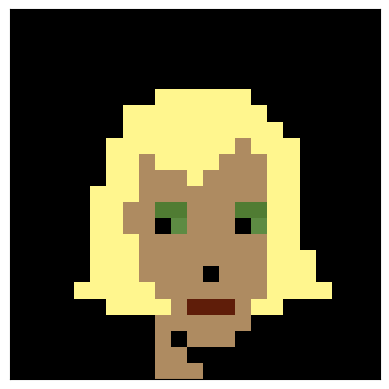

In [ ]:
imgArray = np.asarray(img)
plt.imshow(imgArray[0 : 23, 0 : 23, :])
plt.xticks([])
plt.yticks([])


Here's punks 0 : 24. You can double check that the reference image is filling by rows associated with the punk's index by looking at links like these (change the final number which is the punk's index):

*   https://www.larvalabs.com/cryptopunks/details/0
*   https://www.larvalabs.com/cryptopunks/details/1



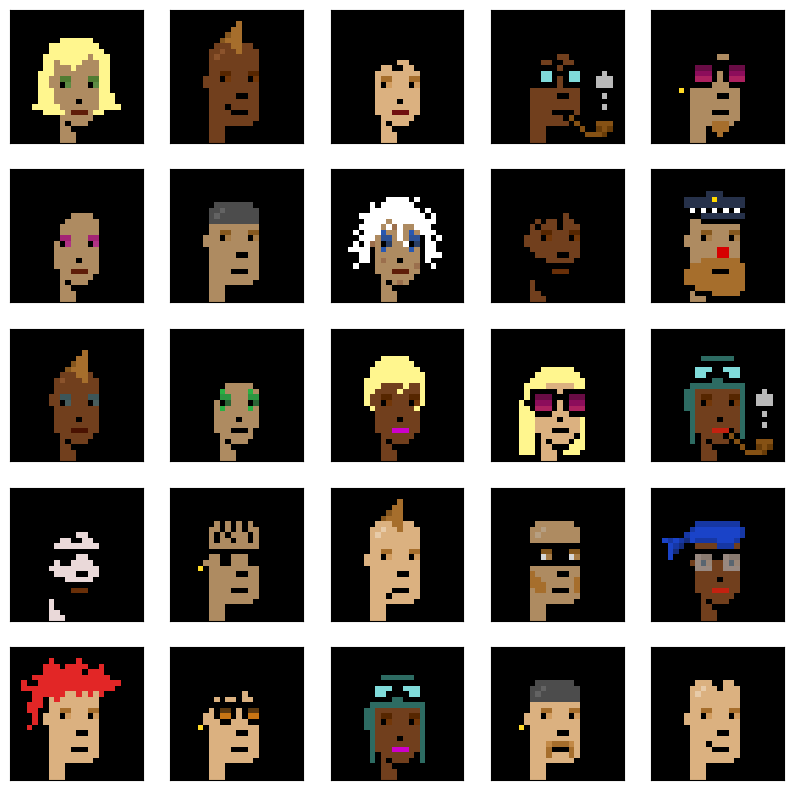

In [ ]:
#Plot out the first 25 punks
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  a, b = (24 * i), (24 * (i + 1))
  plt.imshow(imgArray[0 : 24, a : b, :])

Reorder the array. I couldn't get reshape to do this right, but I think this is a one-line command waiting to happen. See if you can figure out a better way. All images are 24x24x3 and there's 10,000 punks. (Supposedly, there will only ever be 10k punks.) When I did this for tensorflow, it required 24x24x3. However, torch wants 3x24x24.


In [ ]:
finalArray = np.empty((10000, 3, 24, 24))
for i in range(100):
  for j in range(100):
    a, b = 24 * i, 24 * (i + 1)
    c, d = 24 * j, 24 * (j + 1)
    idx = j + i * (100)
    finalArray[idx,0,:,:] = imgArray[a:b,c:d,0]
    finalArray[idx,1,:,:] = imgArray[a:b,c:d,1]
    finalArray[idx,2,:,:] = imgArray[a:b,c:d,2]

Let's normalize our array and split it into testing and training data.

In [ ]:
n = finalArray.shape[0]
trainFraction = .75
sample = np.random.uniform(size = n) < trainFraction
x_train = finalArray[ sample, :, :, :] / 255
x_test =  finalArray[~sample, :, :, :] / 255
[x_train.shape, x_test.shape]

[(7545, 3, 24, 24), (2455, 3, 24, 24)]

We need to figure out which punks have an earring. The Larvalabs website contains information on all of the punks including a search for properties. Thus, one can use our webscraping tools to scrape the page `https://cryptopunks.app/cryptopunks/search?query=Earring`. (However, don't do this since it would cause too many people to be hitting their website at once. Instead, I put the downloaded file in `asssetts`. Note also that I accidentally misspelled assets, but now have too many links to it to change it.)

In [ ]:
from bs4 import BeautifulSoup
import re

file_path = 'assetts/cryptopunks_search_results.mhtml'

with open(file_path, 'r', encoding='utf-8') as file:
    html_content = file.read()

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Find all the <a> tags with the specific pattern in the title attribute
punk_links = soup.find_all('a')

# Extract the numbers from the title attribute
punk_numbers = []
for link in punk_links:
    match = re.search(r'\<a \#(\d+)', link.decode())
    if match:
        punk_numbers.append(int(match.group(1)))

print(punk_numbers[:10])  # Display the first 10 numbers as a sample

# for some reason, I got every number twice
punk_numbers = list(set(punk_numbers))

[0, 4, 5, 16, 21, 23, 27, 29, 35, 45]


In [ ]:
dat1 = pd.DataFrame({'id' : punk_numbers, 'earring' : 1})
dat = pd.DataFrame({'id' : list(range(0, 10000))})
dat = dat.merge(dat1, on = 'id', how = 'left').fillna(0)

Let's see how we did

In [ ]:
dat.head(17)

id  earring
0    0      1.0
1    1      0.0
2    2      0.0
3    3      0.0
4    4      1.0
5    5      1.0
6    6      0.0
7    7      0.0
8    8      0.0
9    9      0.0
10  10      0.0
11  11      0.0
12  12      0.0
13  13      0.0
14  14      0.0
15  15      0.0
16  16      1.0

Let's see the distribution of earrings.

In [ ]:
dat.earring.value_counts(normalize=True)

0.0    0.7541
1.0    0.2459
Name: earring, dtype: float64

Let's get our y values.

In [ ]:
y_train = dat.earring[sample].to_numpy()
y_test =  dat.earring[~sample].to_numpy()

## Need to have the extra dimension
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

## Pytorch

OK, now let's follow along with [this example](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) and train a classifier. However, they do a lot of the data organization ahead of time. So, first we have to convert our training data and testing data into pytorch tensors. Then convert them into a dataset format. Then, convert them into a dataloader. The dataloader is useful since it will do things like automate the batch creation for us.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms

trainDataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainloader = torch.utils.data.DataLoader(trainDataset, batch_size = 100, shuffle = False, num_workers = 1)

Let's use their CIFAR code to check some of our images and labels.

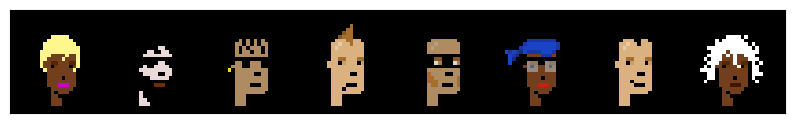

tensor([0., 0., 1., 0., 0., 0., 0., 0.])

In [ ]:

dataiter = iter(trainloader)
images, labels = next(dataiter)


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)


# show images

plt.figure(figsize = (10, 10))
imshow(torchvision.utils.make_grid(images[11 : 19, :, :, :]))

# print labels
labels[11 : 19,0]

In [ ]:
## Here's the sort of things we can do with the dataloaders
## basically iterate over the batches and it gives us stuff in
## the right format. Of course, this loop does nothing.
for i, data in enumerate(trainloader, 0):
  # get the inputs; data is a list of [inputs, labels]
  inputs, labels = data
[inputs.shape, labels.shape]

[torch.Size([45, 3, 24, 24]), torch.Size([45, 1])]

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        ## This has to be changed because the size
        ## of our inputs is different than the CFAR
        ## example. There's is 32x32 and ours is 24x24
        ## Also, I changed the rest of the network architecture
        ## here
        ## Finally, we only have one output.
        self.fc1 = nn.Linear(16 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
net = Net()

In [ ]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=144, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


Let's run the inputs through our NN. Note, it outputs 10 (our batch size) and 1 (the number of outcomes we have).

In [ ]:
net(inputs).shape

torch.Size([45, 1])

In [ ]:
import torch.optim as optim
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
#        if i % 2000 == 1999:    # print every 2000 mini-batches
#            print('[%d, %5d] loss: %.3f' %
#                  (epoch + 1, i + 1, running_loss / 2000))
#            running_loss = 0.0

print('Finished Training')

Finished Training


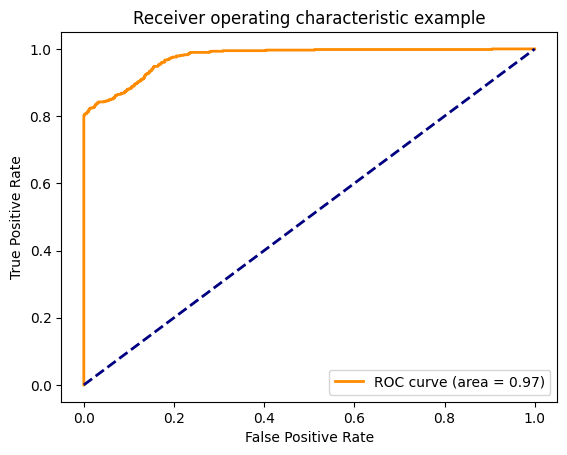

In [ ]:
## Run the testing data through the NN
testout = net(torch.Tensor(x_test)).detach().numpy()

## Compare with the testing labels
from sklearn.metrics import accuracy_score, roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, testout)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()